In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
# ==============================================================================
#                                                         POINT_CLOUD_2_BIRDSEYE
# ==============================================================================
def point_cloud_2_top(points,
                      res=0.1,
                      zres=0.3,
                      side_range=(-10., 10.),  # left-most to right-most
                      fwd_range=(-10., 10.),  # back-most to forward-most
                      height_range=(-2., 2.),  # bottom-most to upper-most
                      ):
    """ Creates an birds eye view representation of the point cloud data for MV3D.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        res:        (float)
                    Desired resolution in metres to use. Each output pixel will
                    represent an square region res x res in size.
        zres:        (float)
                    Desired resolution on Z-axis in metres to use.
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        height_range: (tuple of two floats)
                    (min, max) heights (in metres) relative to the origin.
                    All height values will be clipped to this min and max value,
                    such that anything below min will be truncated to min, and
                    the same for values above max.
    Returns:
        numpy array encoding height features , density and intensity.
    """
    # EXTRACT THE POINTS FOR EACH AXIS
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]
    reflectance = points[:,3]

    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = int((side_range[1] - side_range[0]) / res)
    y_max = int((fwd_range[1] - fwd_range[0]) / res)
    z_max = int((height_range[1] - height_range[0]) / zres)
    # z_max =
    top = np.zeros([y_max+1, x_max+1, z_max+1], dtype=np.float32)

    # FILTER - To return only indices of points within desired cube
    # Three filters for: Front-to-back, side-to-side, and height ranges
    # Note left side is positive y axis in LIDAR coordinates
    f_filt = np.logical_and(
        (x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt = np.logical_and(
        (y_points > -side_range[1]), (y_points < -side_range[0]))
    filter = np.logical_and(f_filt, s_filt)


    # # ASSIGN EACH POINT TO A HEIGHT SLICE
    # # n_slices-1 is used because values above max_height get assigned to an
    # # extra index when we call np.digitize().
    # bins = np.linspace(height_range[0], height_range[1], num=n_slices-1)
    # slice_indices = np.digitize(z_points, bins=bins, right=False)
    # # RESCALE THE REFLECTANCE VALUES - to be between the range 0-255
    # pixel_values = scale_to_255(r_points, min=0.0, max=1.0)
    # FILL PIXEL VALUES IN IMAGE ARRAY
    # -y is used because images start from top left
    # x_max = int((side_range[1] - side_range[0]) / res)
    # y_max = int((fwd_range[1] - fwd_range[0]) / res)
    # im = np.zeros([y_max, x_max, n_slices], dtype=np.uint8)
    # im[-y_img, x_img, slice_indices] = pixel_values


    for i, height in enumerate(np.arange(height_range[0], height_range[1], zres)):

        z_filt = np.logical_and((z_points >= height),
                                (z_points < height + zres))
        zfilter = np.logical_and(filter, z_filt)
        indices = np.argwhere(zfilter).flatten()

        # KEEPERS
        xi_points = x_points[indices]
        yi_points = y_points[indices]
        zi_points = z_points[indices]
        ref_i = reflectance[indices]

        # print(f_filt.shape)

        # CONVERT TO PIXEL POSITION VALUES - Based on resolution
        x_img = (-yi_points / res).astype(np.int32)  # x axis is -y in LIDAR
        y_img = (-xi_points / res).astype(np.int32)  # y axis is -x in LIDAR

        # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
        # floor & ceil used to prevent anything being rounded to below 0 after
        # shift
        x_img -= int(np.floor(side_range[0] / res))
        y_img += int(np.floor(fwd_range[1] / res))

        # CLIP HEIGHT VALUES - to between min and max heights
        pixel_values = zi_points - height_range[0]
        # pixel_values = zi_points

        # FILL PIXEL VALUES IN IMAGE ARRAY
        top[y_img, x_img, i] = pixel_values

        # max_intensity = np.max(prs[idx])
        top[y_img, x_img, z_max] = ref_i

    return top

In [26]:
root_dir = "/workspace/MV3D_TF/data/KITTI/object/testing"
velodyne = os.path.join(root_dir, "velodyne/")
bird = os.path.join(root_dir, "lidar_bv/")
side_range = (-30., 30.)
fwd_range = (0., 60)
height_range = (-2, 0.4) #


In [27]:
i = 1

In [35]:
filename = velodyne + str(i).zfill(6) + ".bin"
print("Processing: ", filename)


('Processing: ', '/workspace/MV3D_TF/data/KITTI/object/testing/velodyne/000001.bin')


In [36]:
scan = np.fromfile(filename, dtype=np.float32)
print(type(scan))
print(scan.shape)
print(scan.ndim)

<type 'numpy.ndarray'>
(488436,)
1


In [37]:
scan = scan.reshape((-1, 4))
print(type(scan))
print(scan.shape)
print(scan.ndim)

<type 'numpy.ndarray'>
(122109, 4)
2


In [38]:
bird_view = point_cloud_2_top(scan, res=0.1, zres=0.3,
                               side_range=side_range,  # left-most to right-most
                               fwd_range=fwd_range,  # back-most to forward-most
                               height_range=height_range)

In [39]:
print(type(bird_view))
print(bird_view.shape)
print(bird_view.ndim)

<type 'numpy.ndarray'>
(601, 601, 9)
3


In [48]:
#save
np.save("bird"+str(i).zfill(6)+".npy",bird_view)

(601, 601, 9)


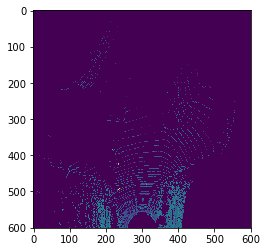

In [51]:
# test
test = np.load("bird" + str(i).zfill(6) + ".npy")
print(test.shape)
plt.imshow(test[:,:,8])
plt.show()

```python
for i in range(7517):
    filename = velodyne + str(i).zfill(6) + ".bin"
    print("Processing: ", filename)
    scan = np.fromfile(filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))
    bird_view = point_cloud_2_top(scan, res=0.1, zres=0.3,
                                   side_range=side_range,  # left-most to right-most
                                   fwd_range=fwd_range,  # back-most to forward-most
                                   height_range=height_range)
    #save
    np.save(bird+str(i).zfill(6)+".npy",bird_view)
```

